In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import RawMLPChromosome


low, high = RawMLPChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 2, 4, 3, 1, 1, 6, 3]))

In [8]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas_params import NasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset
from src.nas.plot import hist_accuracies


DatasetClass = BreastCancerDataset
params = NasParams(
    epochs=15,
    patience=5,
    amount_of_evaluations=1,
    population_size=30,
    population_offspring_count=10,
    algorithm_generations=1,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

(93.6, np.float64(2678.4))

In [9]:
plow = problem.get_nn_params(RawMLPChromosome(low).parse())
phigh = problem.get_nn_params(RawMLPChromosome(high).parse())

plow.get_complexity(), phigh.get_complexity()

(93.6, np.float64(2678.4))

In [6]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

if params.population_store_file is not None:
    params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file loaded from `VertebralDataset_population.csv` successfully


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        1 |      1 |             - |             -
Solutions: [[4 2 1 2 4 0 4 2 2 2 1 0 0 2 2]]
Objectives: [[-0.61290323  0.02452134]]


In [7]:
df = problem.result_as_df(res)
df

,Accuracy,Complexity,fc,train,Chromosome
0,61.290323,116.177107,"{'layers': [{'height': 6, 'compression': NNPar...",{'DatasetCls': <class 'src.datasets.vertebral_...,"[4, 2, 1, 2, 4, 0, 4, 2, 2, 2, 1, 0, 0, 2, 2]"


In [12]:
from pprint import pprint

ch = RawMLPChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=6,
                                            weight_qmode=<NNParamsCompMode.NBITS: 'nbits'>,
                                            weight_bitwidth=8),
                              FCLayerParams(height=np.int64(6),
                                            weight_qmode=<NNParamsCompMode.NBITS: 'nbits'>,
                                            weight_bitwidth=8),
                              FCLayerParams(height=3,
                                            weight_qmode=<NNParamsCompMode.NONE: 'none'>,
                                            weight_bitwidth=32)],
                      activation=ActivationParams(activation=<Activation.BINARIZE_RESTE: 'binary_ReSTE'>,
                                                  binary_qmode=<QMode.DET: 'det'>,
                                                  reste_o=3.0,
                                                  reste_threshold=1.5),
                      qmode=<QMode.D

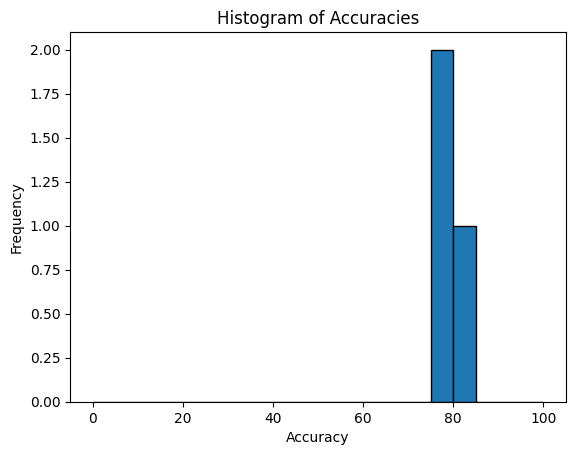

In [13]:
fig = hist_accuracies(df["Accuracy"])

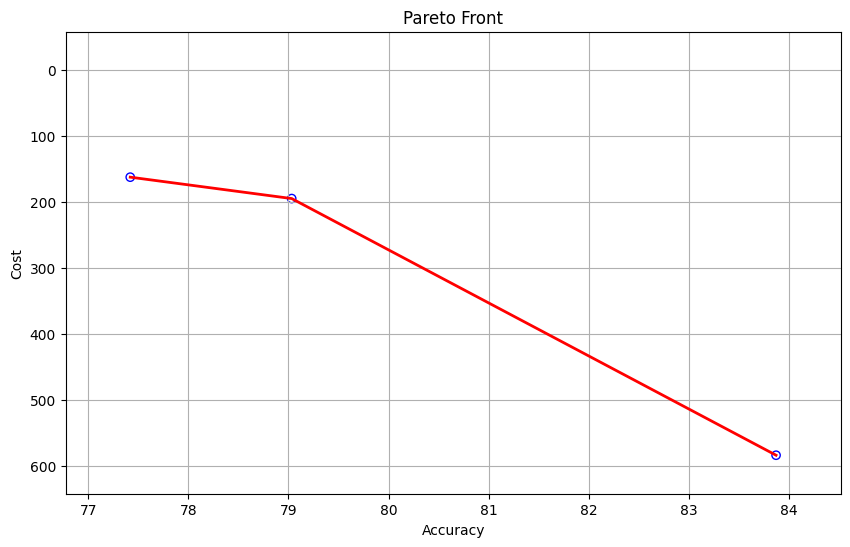

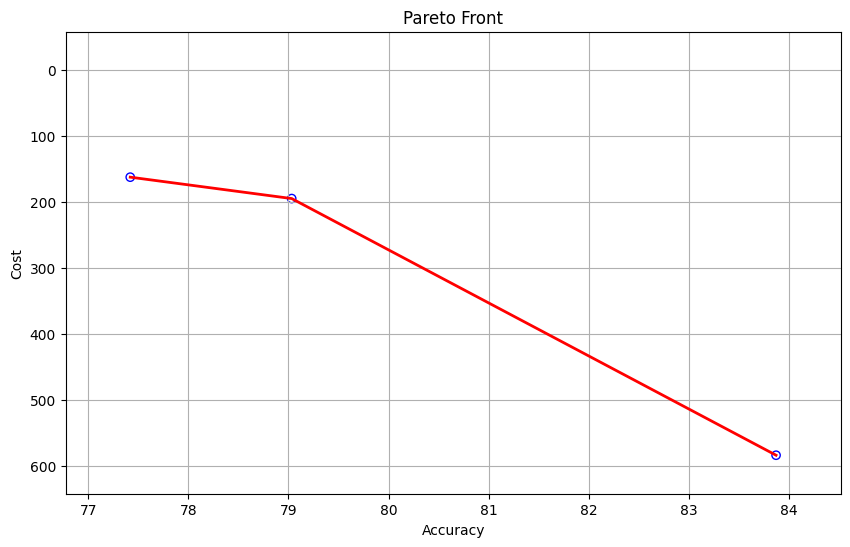

In [10]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])